# Import Library

In [80]:
from pathlib import Path
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from omegaconf import OmegaConf


In [81]:
parent_dir = Path().resolve().parent
print(f"current dir: {parent_dir}")

current dir: C:\Code\Python_Code\analysis_brain_data


# Read Config

In [82]:
config = OmegaConf.load("config\\analysis.yaml")

brain_data_path = parent_dir / Path(config.paths.brain_data_path)
print(brain_data_path)

C:\Code\Python_Code\analysis_brain_data\data\mori_metric.csv


# Load Data And Processing

In [83]:
data = pd.read_csv(brain_data_path)
data.head()

,#時刻,脳血流(左),脳血流(左).1,脳血流(右),脳血流(右).1,脈拍(左),脈拍(右),M1,M2,M3,M4,M5,M6
0,6.7,0.015396,-0.085795,-0.097502,-0.212056,78.639080,68.870546,1,0,0,0,0,0
1,6.8,0.013827,-0.087364,-0.097118,-0.211672,78.065310,69.031466,0,0,0,0,0,0
2,6.9,0.013867,-0.087324,-0.096264,-0.210818,77.654451,69.113290,0,0,0,0,0,0
3,7.0,0.013740,-0.087451,-0.095291,-0.209845,77.699429,69.525719,0,0,0,0,0,0
4,7.1,0.012943,-0.088248,-0.094801,-0.209355,77.412203,70.080115,0,0,0,0,0,0


In [84]:
data_drop = data.drop(columns=["脳血流(左)", "脳血流(右)"])
data_rename = data_drop.rename(columns={"#時刻": "時刻", "脳血流(左).1": "脳血流(左)_shift", "脳血流(右).1": "脳血流(右)_shift"})
data_rename.head()

,時刻,脳血流(左)_shift,脳血流(右)_shift,脈拍(左),脈拍(右),M1,M2,M3,M4,M5,M6
0,6.7,-0.085795,-0.212056,78.639080,68.870546,1,0,0,0,0,0
1,6.8,-0.087364,-0.211672,78.065310,69.031466,0,0,0,0,0,0
2,6.9,-0.087324,-0.210818,77.654451,69.113290,0,0,0,0,0,0
3,7.0,-0.087451,-0.209845,77.699429,69.525719,0,0,0,0,0,0
4,7.1,-0.088248,-0.209355,77.412203,70.080115,0,0,0,0,0,0


In [85]:
split_index = []

for i, (idx, row) in enumerate(data_rename.iterrows()):
    for m in ['M1', 'M2', 'M3', 'M4', 'M5', 'M6']:
        if row[m] == 1:
            split_index.append(i)

print(f"split_indexs: {split_index}")

split_indexs: [0, 409, 809, 1211]


In [86]:
split_datasets = {
    "zero_back_1": data_rename.iloc[split_index[0]:split_index[1]],
    "two_back": data_rename.iloc[split_index[1]:split_index[2]],
    "zero_back_2": data_rename.iloc[split_index[2]:split_index[3]],
    }

# Plot Data

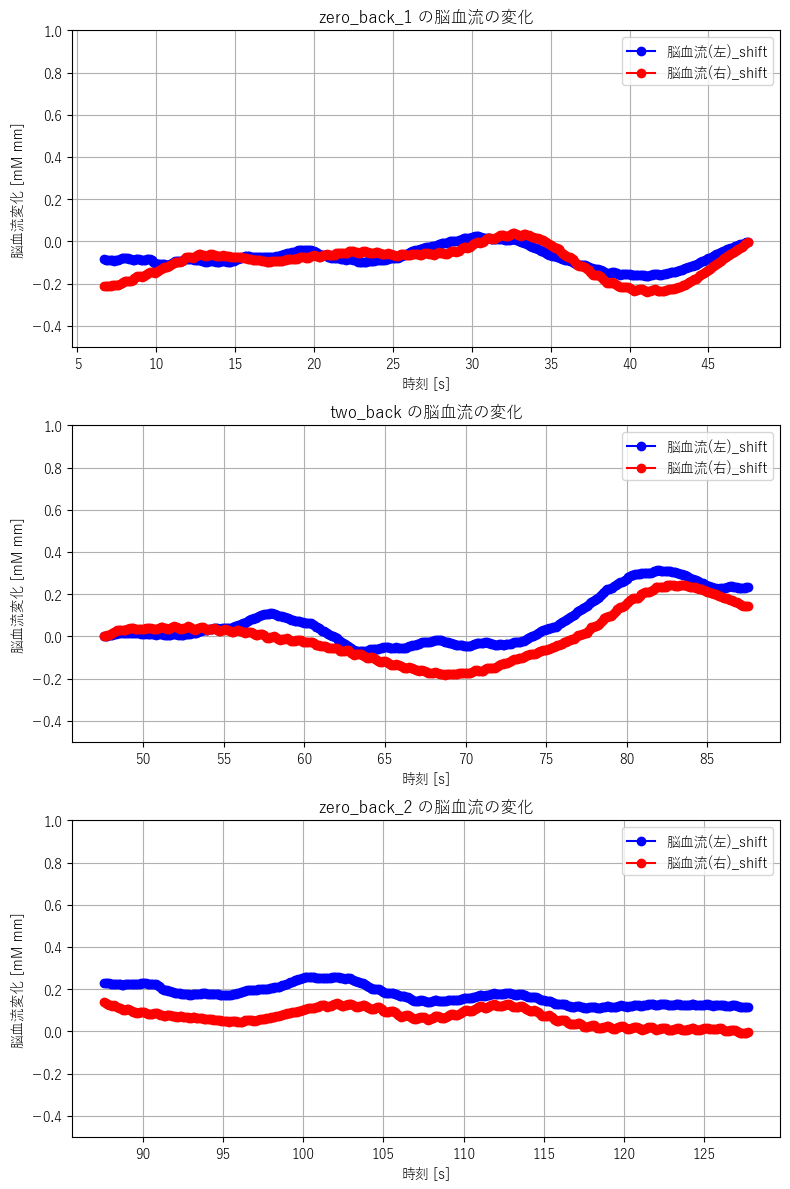

In [87]:
matplotlib.rcParams['font.family'] = 'Yu Gothic' # 日本語フォントを設定

plt.figure(figsize=(8, 12))

for i, (name, data) in enumerate(split_datasets.items(), 1):
    plt.subplot(3, 1, i)
    plt.plot(data['時刻'], data['脳血流(左)_shift'], label='脳血流(左)_shift', color='blue', marker='o')
    plt.plot(data['時刻'], data['脳血流(右)_shift'], label='脳血流(右)_shift', color='red', marker='o')

    plt.xlabel('時刻 [s]')
    plt.ylabel('脳血流変化 [mM mm]')
    plt.ylim(-0.5, 1.0)
    plt.title(f'{name} の脳血流の変化')

    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# LinearRegression And Plot Data

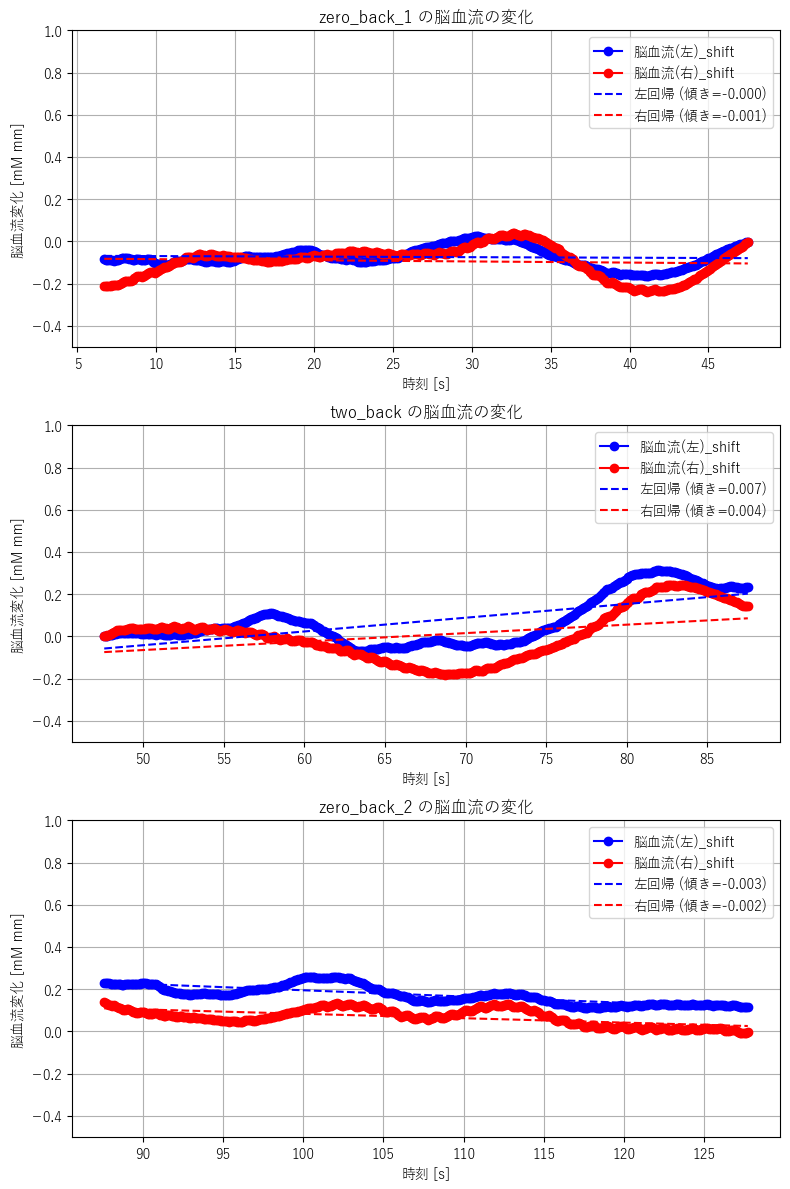

In [88]:
plt.figure(figsize=(8, 12))

for i, (name, data) in enumerate(split_datasets.items(), 1):
    plt.subplot(3, 1, i)

    x = data['時刻'].values.reshape(-1, 1)  
    y_left = data['脳血流(左)_shift'].values
    y_right = data['脳血流(右)_shift'].values

    model_left = LinearRegression()
    model_left.fit(x, y_left)
    y_left_fit = model_left.predict(x)
    slope_left = model_left.coef_[0]

    model_right = LinearRegression()
    model_right.fit(x, y_right)
    y_right_fit = model_right.predict(x)
    slope_right = model_right.coef_[0]

    plt.plot(x, y_left, label='脳血流(左)_shift', color='blue', marker='o')
    plt.plot(x, y_right, label='脳血流(右)_shift', color='red', marker='o')

    plt.plot(x, y_left_fit, label=f'左回帰 (傾き={slope_left:.3f})', color='blue', linestyle='--')
    plt.plot(x, y_right_fit, label=f'右回帰 (傾き={slope_right:.3f})', color='red', linestyle='--')

    plt.xlabel('時刻 [s]')
    plt.ylabel('脳血流変化 [mM mm]')
    plt.ylim(-0.5, 1.0)
    plt.title(f'{name} の脳血流の変化')

    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()